In [1]:
import glob
import itertools
from collections import Counter

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from gimmemotifs.motif import Motif, read_motifs
from gimmemotifs.comparison import MotifComparer

from nopeak_utils.nopeak import NoPeakMotif

%matplotlib inline

In [2]:
all_motifs = list(itertools.chain.from_iterable(NoPeakMotif.from_file(infile, strip_edges=False) for infile in glob.glob("data/*.motifs.*")))

In [3]:
print(len(glob.glob("data/*.motifs.*")))
print(len(all_motifs))

150
563


In [4]:
pd.DataFrame({ "motif" : [motif.id for motif in all_motifs], "information_content": [motif.information_content() for motif in all_motifs]})

,motif,information_content
0,ENCFF775QDK_dedup.bam.motifs_0,207.994347
1,ENCFF775QDK_dedup.bam.motifs_1,1082.126698
2,ENCFF775QDK_dedup.bam.motifs_2,486.608347
3,SRR3180007_dedup.bam.motifs_0,849.233479
4,SRR3180007_dedup.bam.motifs_1,114.729056
...,...,...
558,SRR299377_dedup.bam.motifs_0,575.331912
559,SRR299377_dedup.bam.motifs_1,1718.742901
560,SRR604585_dedup.bam.motifs_0,4245.212794
561,SRR604585_dedup.bam.motifs_1,58.000000


<AxesSubplot:xlabel='information_content', ylabel='Count'>

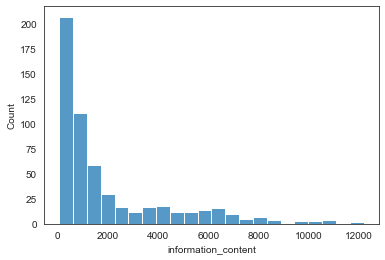

In [5]:
sns.histplot(data=pd.DataFrame({"information_content": list(map(Motif.information_content, all_motifs))}), x="information_content")

In [6]:
high_ic_motifs = [ motif for motif in all_motifs if motif.information_content() > 1000 ]

In [7]:
# print(len(high_ic_motifs))
mc = MotifComparer()
# best_matching_motifs = mc.get_closest_match(high_ic_motifs, dbmotifs=read_motifs("HOMER"), metric="seqcor", parallel=False)

In [8]:
# best_matching_motifs

In [9]:
# [ motif.id for motif in high_ic_motifs ]

<AxesSubplot:ylabel='Density'>

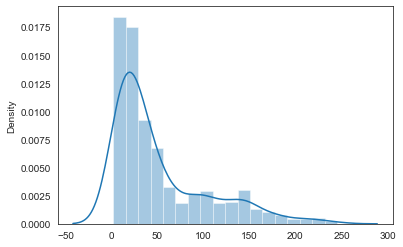

In [10]:
sns.distplot([ motif.kmer_count for motif in all_motifs ])

In [33]:
high_kmer_motifs = [motif for motif in all_motifs if int(motif.kmer_count) > 100]

In [34]:
print(len(high_kmer_motifs ))
mc = MotifComparer()
best_matching_motifs = mc.get_closest_match(high_kmer_motifs, dbmotifs=read_motifs("HOMER"), metric="seqcor", parallel=False)

100


In [35]:
len(best_matching_motifs)

100

In [36]:
def get_tf_from_name(name):
    identifier = name[0].split('/')[1]
    if not "-" in identifier:
        return identifier
    else:
        return identifier.split('-')[1]

In [37]:
closest_tf = [get_tf_from_name(motif) for motif in best_matching_motifs.values()]
Counter([get_tf_from_name(motif) for motif in best_matching_motifs.values()])

Counter({'CTCFL': 36,
         'CTCF': 39,
         'ZBTB18.GFP': 1,
         'NF1': 9,
         'RORgt.Flag': 1,
         'IRF2': 1,
         'PBX1': 1,
         'ZSCAN22.GFP': 1,
         'CellCycle': 3,
         'Atf7': 1,
         'Hoxd13': 1,
         'cMyc': 1,
         'Pit1': 1,
         'EBF': 1,
         'Prep1': 1,
         'Nr2f2': 1,
         'Srebp2': 1})

In [38]:
len({ motif.id for motif in high_kmer_motifs })

100

In [39]:
affinities = [ [ mc.compare_motifs(motif_1, motif_2)[0] for motif_1 in high_kmer_motifs ] for motif_2 in high_kmer_motifs ]

<AxesSubplot:>

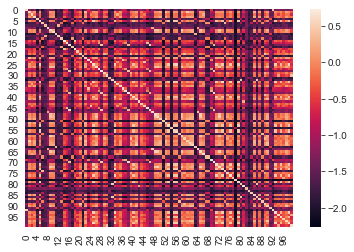

In [40]:
sns.heatmap(affinities)

In [41]:
{len(motif.pwm) for motif in high_kmer_motifs}

{24}

In [42]:
scaled_pwms = StandardScaler().fit_transform([ list(itertools.chain(*motif.pwm)) for motif in high_kmer_motifs ])
pcs = pd.DataFrame(PCA(n_components=2).fit_transform(scaled_pwms), columns=["PC1", "PC2"])
pcs["motif"] = closest_tf

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

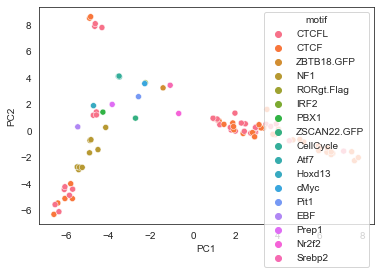

In [43]:
sns.scatterplot(data=pcs, x="PC1", y="PC2", hue="motif")